In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from sklearn.linear_model import LogisticRegression
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.common.monotone_nn import train_monotonic_nn, MonotonicNN
from tsi.common.utils import IntList, TrainingLogger
from tsi.temp.utils import kdeplots2D

2025-10-29 14:53:03.794657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-29 14:53:03.794726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-29 14:53:03.796684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-29 14:53:03.805778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 14:53:05.729432: W tensorflow/compiler/tf2

In [ ]:
# with open('results/test/lf2i_strong_prior.pkl', 'rb') as f:
#     lf2i = dill.load(f)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Prior: N(0, 2I)
def log_prior(theta):
    return multivariate_normal.logpdf(theta, mean=[0, 0], cov=2*np.eye(2))

# Log-likelihood: log(0.5*N(x|theta,I) + 0.5*N(x|theta,I/10))
def log_likelihood(x, theta):
    ll1 = multivariate_normal.logpdf(x, theta, np.eye(2))
    ll2 = multivariate_normal.logpdf(x, theta, 0.1*np.eye(2))
    return np.logaddexp(ll1 + np.log(0.5), ll2 + np.log(0.5))

# Log posterior (unnormalized)
def log_posterior(theta, x):
    return log_prior(theta) + log_likelihood(x, theta)

def sample_likelihood(theta0, n_samples=10000):
    # Sample X from likelihood at theta0
    n1 = np.random.binomial(n_samples, 0.5)
    x1 = np.random.randn(n1, 2) + theta0  # from N(theta0, I)
    x2 = np.random.randn(n_samples - n1, 2) * np.sqrt(0.1) + theta0  # from N(theta0, I/10)
    x_samples = np.vstack([x1, x2])
    
    return x_samples

# Sample X values to get distribution of log pi(theta0 | X)
def sample_log_posterior_dist(theta0, n_samples=10000):
    # Sample X from likelihood at theta0
    n1 = np.random.binomial(n_samples, 0.5)
    x1 = np.random.randn(n1, 2) + theta0  # from N(theta0, I)
    x2 = np.random.randn(n_samples - n1, 2) * np.sqrt(0.1) + theta0  # from N(theta0, I/10)
    x_samples = np.vstack([x1, x2])
    
    # Compute log posterior for each X
    log_posts = np.array([log_posterior(theta0, x) for x in x_samples])
    return log_posts

In [105]:
b_prime_params = 2.0 * np.random.randn(10_000, 2) # np.random.randn(0, 2.0, 10_000).reshape(-1, 2)
b_prime_radius = np.linalg.norm(b_prime_params, axis=1).reshape(-1, 1)
b_prime_samples = np.vstack([sample_likelihood(theta0, 1) for theta0 in b_prime_params])
b_prime_test_statistics = np.vstack([log_posterior(theta0, x0) for (theta0, x0) in zip(b_prime_params, b_prime_samples)])
b_prime_ts = np.random.uniform(b_prime_test_statistics.min(), b_prime_test_statistics.max(), b_prime_test_statistics.shape)

augmented_inputs, rejection_indicators = np.hstack([b_prime_test_statistics, b_prime_params, b_prime_radius]), (b_prime_ts > b_prime_test_statistics).astype(int)

# Estimate p-value function

In [106]:
from pygam import LogisticGAM, s, te

gam_params = {}
n_splines_T = gam_params.get('n_splines_T', 12)
n_splines_radius = gam_params.get('n_splines_radius', 5)
spline_order = gam_params.get('spline_order', 3)
lam_range = gam_params.get('lam_range', np.logspace(0, 5, 11))
include_interaction = gam_params.get('include_interaction', False)

In [117]:
# Build GAM formula
monotone_constraint = 'monotonic_inc'

if include_interaction:
    gam_formula = (
        s(0, constraints=monotone_constraint, n_splines=n_splines_T, spline_order=spline_order) +
        s(3, n_splines=n_splines_radius, spline_order=spline_order) +
        te(0, 3)
    )
else:
    gam_formula = (
        s(0, constraints=monotone_constraint, n_splines=n_splines_T, spline_order=spline_order) +
        s(3, n_splines=n_splines_radius, spline_order=spline_order)
    )

algorithm = LogisticGAM(gam_formula)

In [121]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Include transformations as needed
class GAMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, gam_formula):
        self.gam_formula = gam_formula
        self.gam_model = LogisticGAM(gam_formula)
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        self.gam_model.gridsearch(
            X,
            y,
            lam=np.logspace(0, 5, 11),
            progress=False
        )
        return self
    
    def predict(self, X):
        X_with_radius = np.column_stack([X, np.linalg.norm(X[:, [1, 2]], axis=1)])
        return self.gam_model.predict(X_with_radius)
    
    def predict_proba(self, X):
        X_with_radius = np.column_stack([X, np.linalg.norm(X[:, [1, 2]], axis=1)])
        probs = self.gam_model.predict_proba(X_with_radius)
        return np.column_stack([1 - probs, probs])  # Return [P(class=0), P(class=1)]

# algorithm.gridsearch(
#     augmented_inputs, 
#     rejection_indicators, 
#     lam=lam_range,
#     progress=True
# )


estimator = GAMWrapper(gam_formula)
estimator.fit(augmented_inputs, rejection_indicators)

GAMWrapper(gam_formula=s(0) + s(3))

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

estimator_scaled = CalibratedClassifierCV(
    estimator=GAMWrapper,
    method='sigmoid',
    cv=5,
    n_jobs=-2
)
algorithm.fit(X=inputs, y=rejection_indicators)

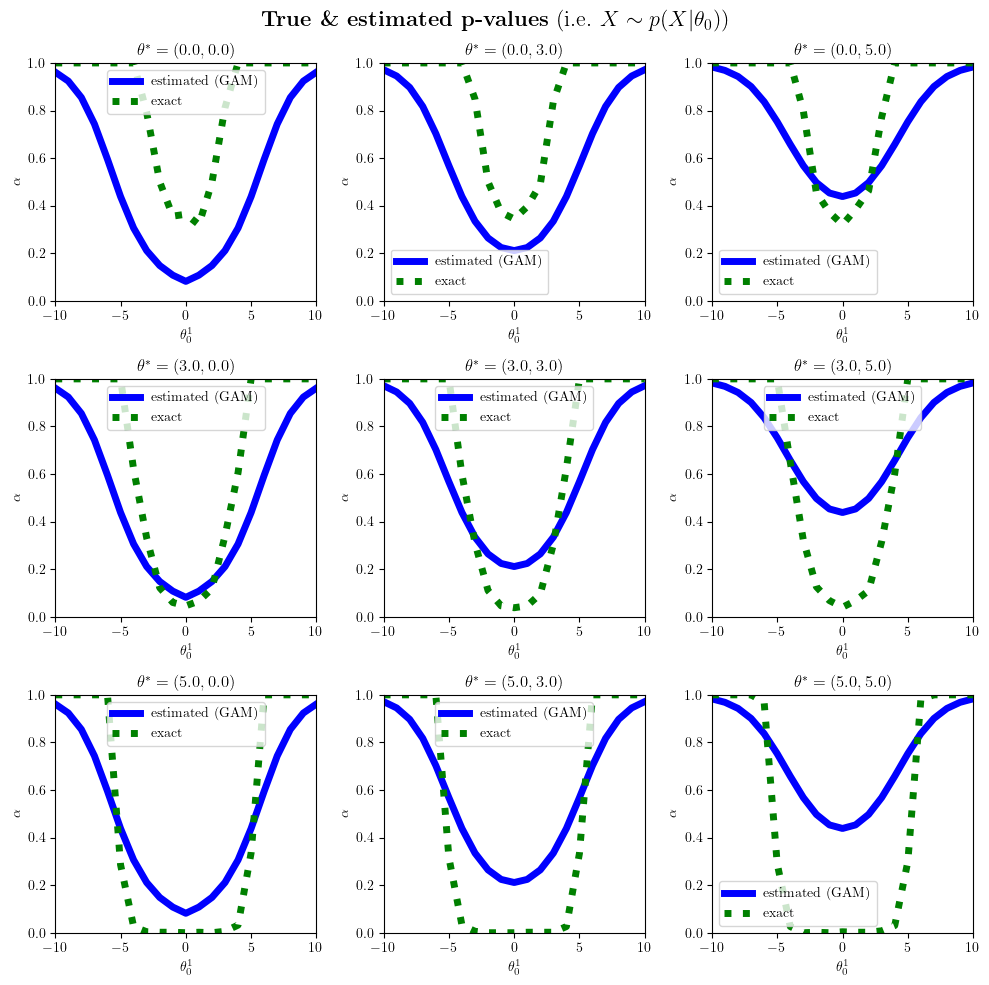

In [111]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
alpha = 0.68

for theta_01, idx in zip([torch.tensor([0.]), torch.tensor([3.]), torch.tensor([5.])], range(3)):
    for theta_02, jdx in zip([torch.tensor([0.]), torch.tensor([3.]), torch.tensor([5.])], range(3)):
        t_val = np.quantile(sample_log_posterior_dist(np.array([theta_01.item(), theta_02.item()]), 500), 1 - alpha)
        theta_range = np.linspace(-10, 10, 21).reshape(-1, 1)

        # Estimated
        X = np.hstack([
            t_val*np.ones_like(theta_range),
            theta_range,
            theta_02.item()*np.ones_like(theta_range)
        ])
        p_value_evaluated = algorithm.predict_proba(X)[:, 1]

        # Exact
        q_extended = np.array([
            np.mean(t_val > sample_log_posterior_dist(np.array([theta_01i.item(), theta_02.item()]), 500)) for theta_01i in theta_range
        ])

        # Plot
        ax = axs[idx, jdx]
        ax.plot(theta_range, p_value_evaluated, label='estimated (GAM)', c='b', linewidth=5)
        ax.plot(theta_range, q_extended, label='exact', c='g', linestyle=':', linewidth=5)
        ax.set_xlabel('$\\theta_0^1$')
        ax.set_ylabel('$\\alpha$')
        ax.set_xlim(-10, 10)
        ax.set_ylim(0, 1)
        ax.set_title(f'$\\theta^*=({theta_01[0]}, {theta_02[0]})$')
        ax.legend()

fig.suptitle('\\textbf{True \& estimated p-values} (i.e.~$X\sim p(X\\vert\\theta_0)$)', fontweight='bold', fontsize=16)
fig.tight_layout()
fig.show()

# Evaluating GAM-based p-values

## As a function of $\alpha$

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Prior: N(0, 2I)
def log_prior(theta):
    return multivariate_normal.logpdf(theta, mean=[0, 0], cov=2*np.eye(2))

# Log-likelihood: log(0.5*N(x|theta,I) + 0.5*N(x|theta,I/10))
def log_likelihood(x, theta):
    ll1 = multivariate_normal.logpdf(x, theta, np.eye(2))
    ll2 = multivariate_normal.logpdf(x, theta, 0.1*np.eye(2))
    return np.logaddexp(ll1 + np.log(0.5), ll2 + np.log(0.5))

# Log posterior (unnormalized)
def log_posterior(theta, x):
    return log_prior(theta) + log_likelihood(x, theta)

# Sample X values to get distribution of log pi(theta0 | X)
def sample_log_posterior_dist(theta0, n_samples=10000):
    # Sample X from likelihood at theta0
    n1 = np.random.binomial(n_samples, 0.5)
    x1 = np.random.randn(n1, 2) + theta0  # from N(theta0, I)
    x2 = np.random.randn(n_samples - n1, 2) * np.sqrt(0.1) + theta0  # from N(theta0, I/10)
    x_samples = np.vstack([x1, x2])
    
    # Compute log posterior for each X
    log_posts = np.array([log_posterior(theta0, x) for x in x_samples])
    return log_posts

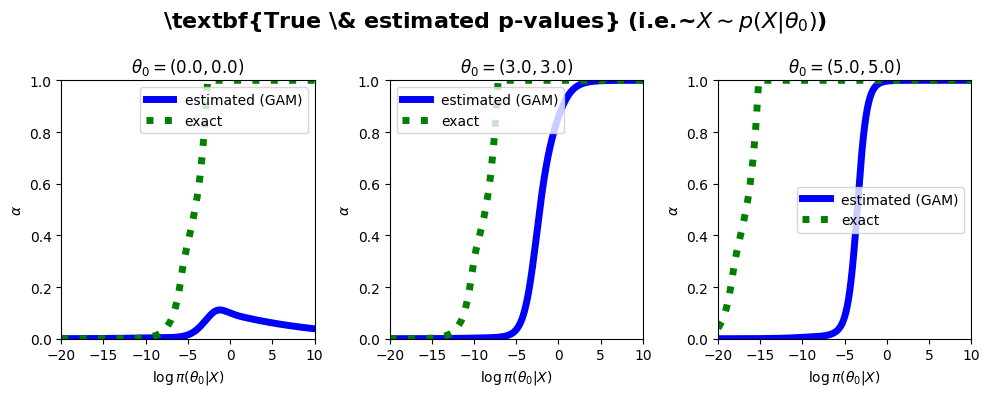

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for theta0, ax in zip([torch.tensor([0., 0.]), torch.tensor([3., 3.]), torch.tensor([5., 5.])], axs):
    t_range = np.linspace(-20, 10, 1000)

    # Estimated
    X = np.hstack([
        t_range.reshape(-1, 1),
        np.repeat(theta0.reshape(1, -1), 1_000, axis=0)
    ])
    p_value_evaluated = lf2i.calibration_model['multiple_levels'].predict_proba(X)[:, 1]

    # Exact
    log_posts = sample_log_posterior_dist(theta0.numpy(), n_samples=20000)
    log_posts_sorted = np.sort(log_posts)
    quantiles = np.linspace(0, 1, len(log_posts_sorted))
    q_extended = np.interp(t_range, log_posts_sorted, quantiles, left=0, right=1)

    # Plot
    ax.plot(t_range, p_value_evaluated, label='estimated (GAM)', c='b', linewidth=5)
    ax.plot(t_range, q_extended, label='exact', c='g', linestyle=':', linewidth=5)
    ax.set_xlabel('$\log\pi(\\theta_0\\vert X)$')
    ax.set_ylabel('$\\alpha$')
    ax.set_xlim(-20, 10)
    ax.set_ylim(0, 1)
    ax.set_title(f'$\\theta_0=({theta0[0]}, {theta0[1]})$')
    ax.legend()

fig.suptitle('\\textbf{True \& estimated p-values} (i.e.~$X\sim p(X\\vert\\theta_0)$)', fontweight='bold', fontsize=16)
fig.tight_layout()
fig.show()

## As a function of $\theta$

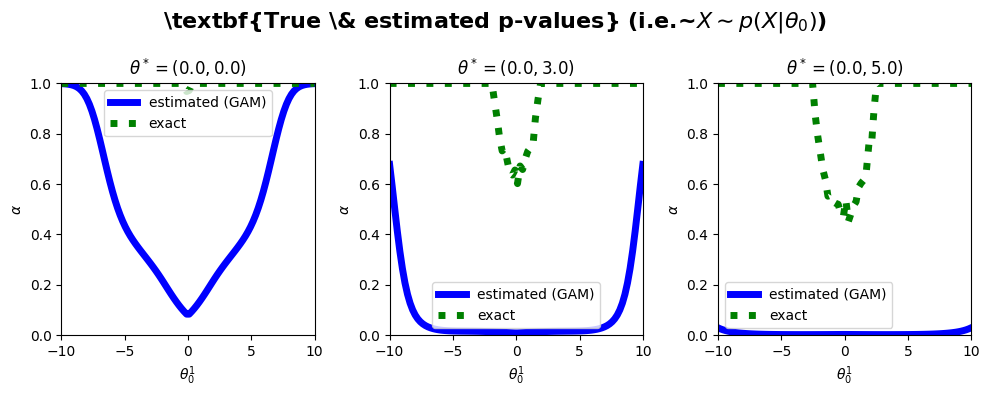

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
alpha = 0.68

for theta_02, ax in zip([torch.tensor([0.]), torch.tensor([3.]), torch.tensor([5.])], axs):
    t_val = sample_log_posterior_dist(np.array([0.0, theta_02.item()]), 1)
    theta_range = np.linspace(-10, 10, 100).reshape(-1, 1)

    # Estimated
    X = np.hstack([
        t_val*np.ones_like(theta_range), # TODO: Replace with quantile
        theta_range,
        np.zeros_like(theta_range)
    ])
    p_value_evaluated = lf2i.calibration_model['multiple_levels'].predict_proba(X)[:, 1]

    # Exact
    q_extended = np.array([
        np.mean(t_val > sample_log_posterior_dist(np.array([theta_01.item(), theta_02.item()]), 500)) for theta_01 in theta_range
    ])

    # Plot
    ax.plot(theta_range, p_value_evaluated, label='estimated (GAM)', c='b', linewidth=5)
    ax.plot(theta_range, q_extended, label='exact', c='g', linestyle=':', linewidth=5)
    ax.set_xlabel('$\\theta_0^1$')
    ax.set_ylabel('$\\alpha$')
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 1)
    ax.set_title(f'$\\theta^*=(0.0, {theta_02[0]})$')
    ax.legend()

fig.suptitle('\\textbf{True \& estimated p-values} (i.e.~$X\sim p(X\\vert\\theta_0)$)', fontweight='bold', fontsize=16)
fig.tight_layout()
fig.show()